## Exploratory Data Analysis

In [59]:
# imports
import os
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn import preprocessing

### Load data

We load three datasets, all recorded from the CWRU experiment @ 3 HP (~1730 RPM), recorded for approx. 10s using the Drive End accelerometer: 

- fault_12k: 0.021" ball fault time series sampled at 12kHz 
- fault_48k: 0.021" ball fault time series sampled at 48kHz
- norm_48k: Normal baseline time series sampled at 48kHz

In [98]:
FILE_PATH = ["..", "data", "processed"]
FILE_DES_MAP = {
    # file_name: (description, sampling rate)
    "b021_3_12_DE": ('0.021" Ball Fault @ 12kHz and 1730 RPM', 12000),
    "b021_3_48_DE": ('0.021" Ball Fault @ 48kHz and 1730 RPM', 48000),
    "norm_3_48_DE": ('Baseline @ 48kHz and 1730 RPM', 48000)
}

RPM = {
    '0': 1797/60, #HP: RPM/60
    '1': 1772/60,
    '2': 1750/60,
    '3': 1730/60
}

def load_data(file_name, data):
    """load data file into the "data" dict, file name as key
    """
    key = file_name.split('.')[0]
    data[key] = pd.read_csv(os.sep.join(FILE_PATH + [file_name]), header=None)
    for k in data:
        data[k] = data[k].rename(columns={0: 'accel'})
        data[k]['time'] = data[k].index
        window = int(k[7:9]+'000')/RPM[k[5]] # assign fixed window sizes depending on RPM and Sampling Rate
        data[k]['id'] = np.array(data[k].index/window, np.int32)


DATA = {}

for f in ['b021_3_12_DE.csv', 'b021_3_48_DE.csv', 'norm_3_48_DE.csv']:
    load_data(f, DATA)


### Utility functions

In [76]:
# display functions
def display_stat(k, v):
    stat_info = ['size', 'min', 'max', 'mean', 'avg power']
    head_fmt = "{:25}"+"{:15}"*len(stat_info)
    line_fmt = "{:15}"+"{:15}"+"{:15.3f}"*(len(stat_info)-1)
    print(head_fmt.format("", *stat_info))
    print(line_fmt.format(k, len(v), np.min(v), np.max(v), np.mean(v), np.var(v)))


def display_spetrum(k, v):
    v = v['accel']
    s = np.abs(np.fft.fft(v))
    # s = np.log(s)
    n = round(len(s)/2)
    # plt.figure()
    plt.subplot(122)
    plt.plot(range(n-1), s[1:n])
    plt.title(k+':spectrum')


In [77]:
# define plotting function
def plot_ts(ts, title, dt):
    # plt.figure()
    plt.subplot(121)
    plt.plot(ts.index*dt, ts['accel'], label='sig')
    plt.xlabel('time (s)')
    plt.ylabel('accel ($m/s^2$)')
    plt.title(title)

In [78]:
# explore the data

def explore_data(data_set):
    # stat
    for k, v in data_set.items():
        v = v['accel']
        display_stat(k, v)
    # time & spectrum info
    for k, v in data_set.items():
        # time info
        des, fs, *_ = FILE_DES_MAP[k]
        plt.figure()
        plt.subplots(2, 2, figsize=(20,5))
        plot_ts(v, des, 1/fs)
        # spectrum info
        display_spetrum(k, v)
        plt.show()

In [79]:
def nomalize_data(data):
    for k, v in data.items():
        v_ = np.array(v['accel']).reshape(-1, 1)
        v_ = preprocessing.StandardScaler().fit_transform(v_)
        data[k]['accel'] = v_[:]

In [80]:
def add_WGN(k, v, snr):
    """add Gaussian White Noise
    PARAMATER:
        data: DataFrame with nomalized signal value
        snr: SNR
    """
    if snr == None:
        return
    pwr_m = 1/(10**(snr/10)) # snr: 10*log(Ps/Pn) and Ps is 1(nomalized)
    v_ = v['accel']
    n = np.random.normal(0, pwr_m, size=len(v_))
    v[k] = np.add(n, v_)[:]

### Explore the data

First, the original data:

                         size           min            max            mean           avg power      
b021_3_12_DE            122136         -0.493          0.576          0.004          0.014
                         size           min            max            mean           avg power      
b021_3_48_DE            486804         -3.418          3.418          0.012          0.104
                         size           min            max            mean           avg power      
norm_3_48_DE            485643         -0.306          0.284          0.012          0.004


<Figure size 432x288 with 0 Axes>

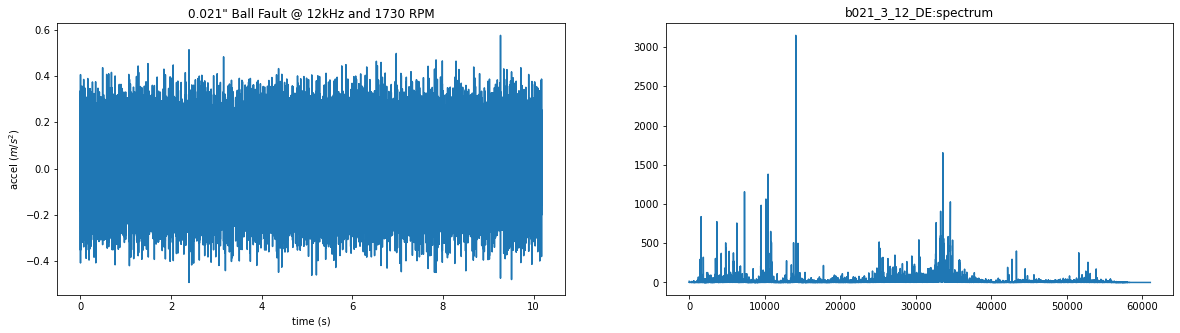

<Figure size 432x288 with 0 Axes>

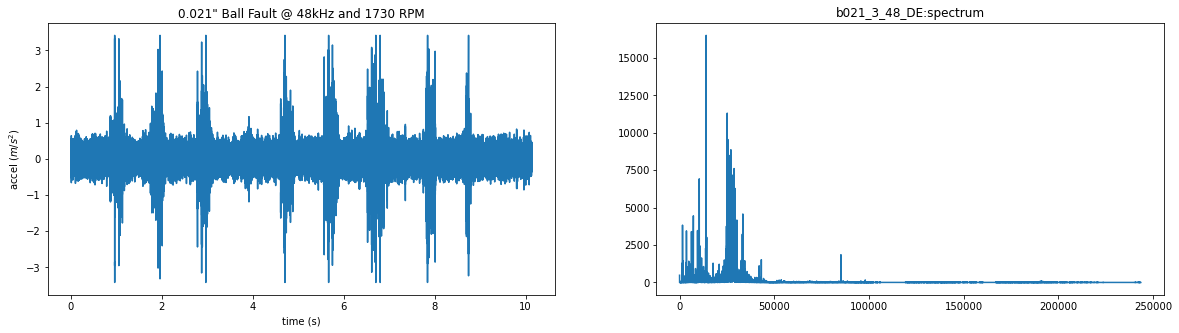

<Figure size 432x288 with 0 Axes>

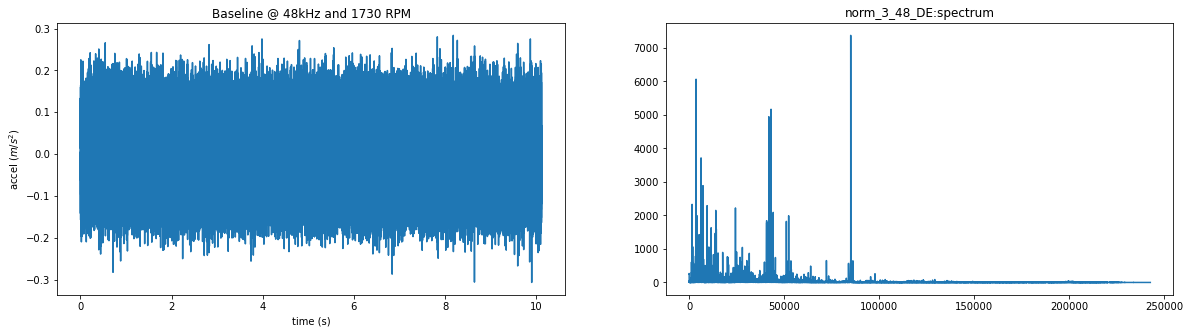

In [81]:
explore_data(DATA)

Nomalize the data:

                         size           min            max            mean           avg power      
b021_3_12_DE            122136         -4.221          4.851          0.000          1.000
                         size           min            max            mean           avg power      
b021_3_48_DE            486804        -10.638         10.564          0.000          1.000
                         size           min            max            mean           avg power      
norm_3_48_DE            485643         -4.930          4.193         -0.000          1.000


<Figure size 432x288 with 0 Axes>

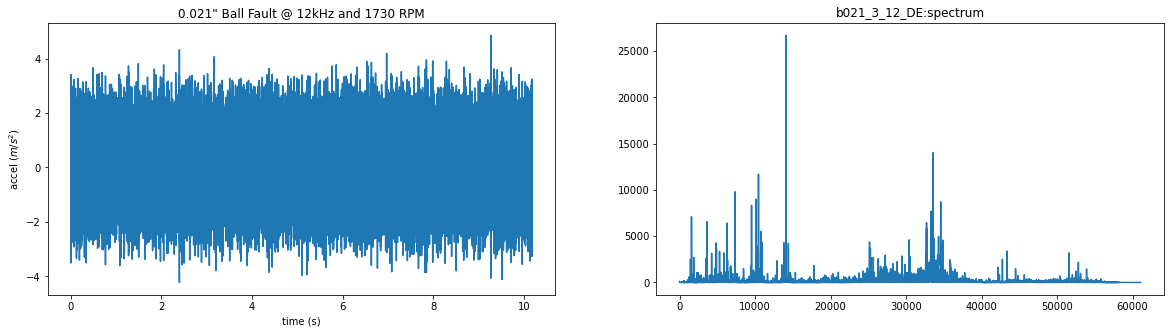

<Figure size 432x288 with 0 Axes>

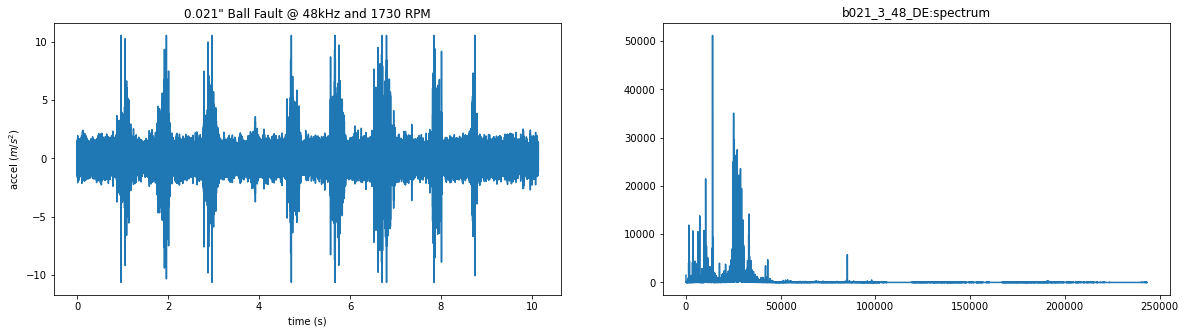

<Figure size 432x288 with 0 Axes>

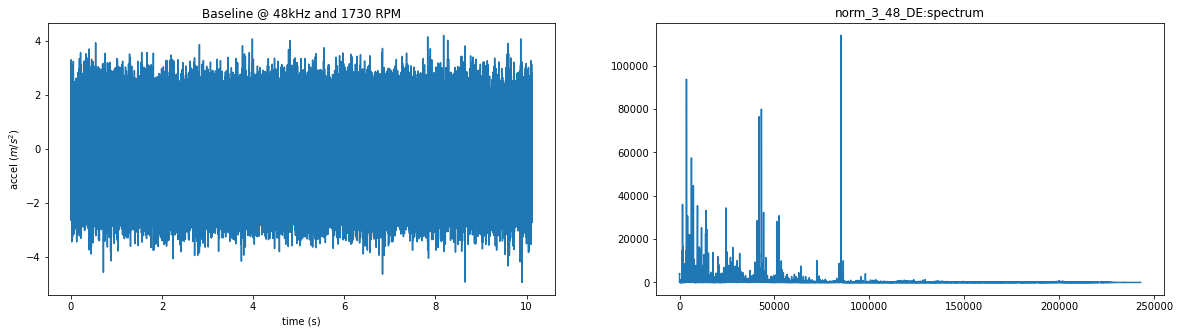

In [82]:
nomalize_data(DATA)
explore_data(DATA)

Add Gaussian White Noise:

                         size           min            max            mean           avg power      
b021_3_12_DE            122136         -4.221          4.851          0.000          1.000
                         size           min            max            mean           avg power      
b021_3_48_DE            486804        -10.638         10.564          0.000          1.000
                         size           min            max            mean           avg power      
norm_3_48_DE            485643         -4.930          4.193         -0.000          1.000


<Figure size 432x288 with 0 Axes>

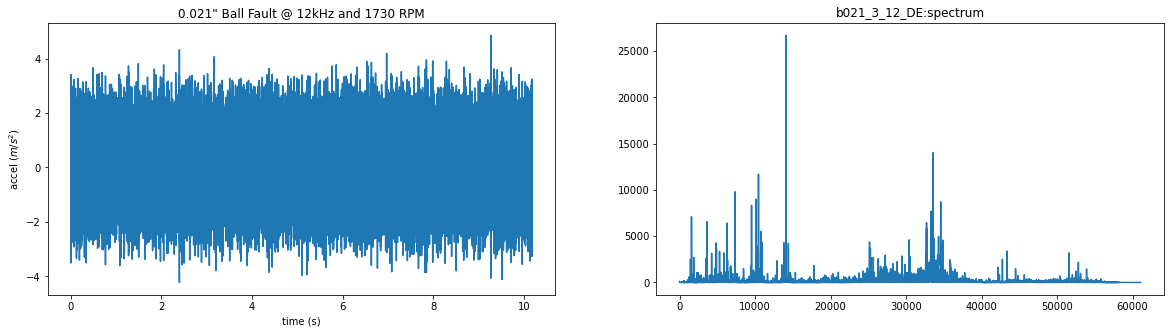

<Figure size 432x288 with 0 Axes>

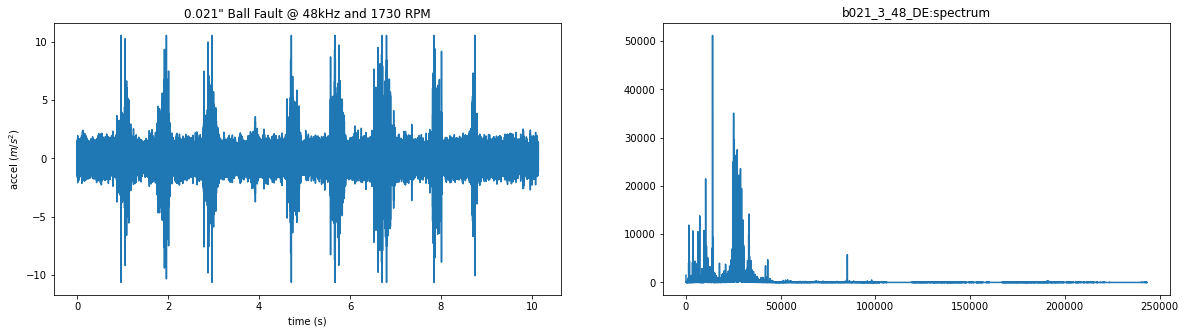

<Figure size 432x288 with 0 Axes>

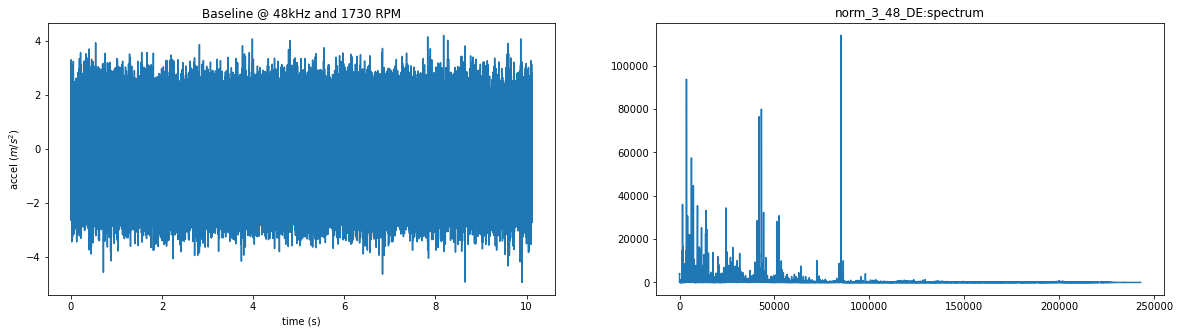

In [83]:
# example: -4db noise
for k, v in DATA.items():
    add_WGN(k, v, -4)
nomalize_data(DATA)  # nomalize after noise added
explore_data(DATA)


### Noise Challenge

In [103]:
# extract minimal feature set
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.feature_extraction import extract_features

minimal_fc = MinimalFCParameters()  # Create dictionary
minimal = sorted(minimal_fc.keys())  # Sort list of dictionary keys
print('Number of feature calculators: ', len(minimal))
print(minimal)

Number of feature calculators:  10
['absolute_maximum', 'length', 'maximum', 'mean', 'median', 'minimum', 'root_mean_square', 'standard_deviation', 'sum_values', 'variance']


In [115]:
# reload everything
DATA = {}
FEATURE_EXTRACTED_DATA = {}

for f in ['b021_3_12_DE.csv', 'b021_3_48_DE.csv', 'norm_3_48_DE.csv']:
    load_data(f, DATA)

for k, v in DATA.items():
    v = v[v['id']!=max(v['id'])] # filter out last ID rows
    X = extract_features(v, column_id='id', column_sort='time',
                default_fc_parameters=minimal_fc)
    if 'norm' in k:
        X['class'] = 0
    else: 
        X['class'] = 1
    FEATURE_EXTRACTED_DATA[k] = X


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37it/s]


In [138]:
horse_power = ['0', '1', '2', '3']
sampling_rate = ['12', '48']

matrices = {}

for hp in horse_power:
    for sr in sampling_rate: 
        df = pd.DataFrame()
        for k, v in FEATURE_EXTRACTED_DATA.items():
            if hp+'_'+sr in k: 
                df = pd.concat([df, v], ignore_index=True)
        if not df.empty:
            if df['class'].nunique() > 1:
                matrices[hp+'_'+sr] = df

In [106]:
# SNR_CHOICES = [-4, -2, 0, 2, 4, 6, 8, 10, None]

# #eload everything
# DATA = {}
# for snr in SNR_CHOICES:
#     for f in ['b021_3_12_DE.csv', 'b021_3_48_DE.csv', 'norm_3_48_DE.csv']:
#         load_data(f, DATA)
    
#     # assign fixed window sizes to each dataframe depending on sampling rate 
#     for k, v in DATA.items():
#         data[]
# #         add_WGN(k, v, snr)

-------

In [ ]:
# rename columns and add time column 
# fault_12k = fault_12k.rename(columns={0: 'accel'})
# fault_48k = fault_48k.rename(columns={0: 'accel'})
# normal_48k = normal_48k.rename(columns={0: 'accel'})

# fault_12k['time'] = fault_12k.index
# fault_48k['time'] = fault_48k.index
# normal_48k['time'] = normal_48k.index

In [ ]:
# plot time series
dt = 1/12000
plot_ts(fault_12k, '0.021" Ball Fault @ 12kHz and 1730 RPM', dt)

In [ ]:
dt = 1/48000
plot_ts(fault_48k, '0.021" Ball Fault @ 48kHz and 1730 RPM', dt)

In [ ]:
dt = 1/48000
plot_ts(normal_48k, 'Baseline @ 48kHz and 1730 RPM', dt)

In [ ]:
# downsample 48k normal to approx. 12k
# normal_12k_val = signal.decimate(normal_48k.accel.values.T, 4)

In [ ]:
normal_12k_val = normal_48k.accel.values[0::4]

In [ ]:
normal_12k_val.shape

In [ ]:
normal_12k = pd.DataFrame(normal_12k_val, columns=['accel'])
normal_12k['time'] = normal_12k.index

In [ ]:
normal_12k

In [ ]:
# plot time series
dt = 1/12000
plot_ts(normal_12k, 'Baseline @ 12kHz and 1730 RPM', dt)

In [ ]:
# plot first 100 points
normal_12k.accel[:100].plot()

In [ ]:
# plot first 400 points
normal_48k.accel[:400].plot()

In [ ]:
# create new column assigning an individual id to windows of sizes corresponding to 1 rev 
normal_48k['id'] = np.array(normal_48k.index/1665, np.int32) 
fault_48k['id'] = np.array(fault_48k.index/1665, np.int32)
normal_12k['id'] = np.array(normal_12k.index/416, np.int32)
fault_12k['id'] = np.array(fault_12k.index/416, np.int32)

In [ ]:
fault_48k

## Extract Features

The extract_features function takes a while, so skip this section if already have preprocessed data files.

In [ ]:
from tsfresh.feature_extraction import extract_features

# X_f48k = extract_features(fault_48k, column_id='id', column_sort='time')
# X_n48k = extract_features(normal_48k, column_id='id', column_sort='time')
# X_f12k = extract_features(fault_12k, column_id='id', column_sort='time')
# X_n12k = extract_features(normal_12k, column_id='id', column_sort='time')

In [ ]:
# X_f48k = pd.read_csv('X_f48k.csv').drop(columns=['Unnamed: 0'])
# X_n48k = pd.read_csv('X_n48k.csv').drop(columns=['Unnamed: 0'])
# X_f12k = pd.read_csv('X_f12k.csv').drop(columns=['Unnamed: 0'])
# X_n12k = pd.read_csv('X_n12k.csv').drop(columns=['Unnamed: 0'])

In [ ]:
# X_f48k

In [ ]:
X_48k = pd.concat([X_f48k, X_n48k], ignore_index=True)
X_12k = pd.concat([X_f12k, X_n12k], ignore_index=True)

In [ ]:
y_48k = np.zeros((len(X_48k),1)) # create labels
y_48k[:len(X_f48k)] = '1'
y_48k[len(X_f48k):len(X_48k)] = '0'

In [ ]:
y_12k = np.zeros((len(X_12k),1))
y_12k[:len(X_f12k)] = '1'
y_12k[len(X_f12k):len(X_48k)] = '0'

In [ ]:
X_48k.shape

In [ ]:
X_48k_real = X_48k.dropna(axis=1) # drop columns with NaN
X_12k_real = X_12k.dropna(axis=1) # drop columns with NaN

In [ ]:
from tsfresh.transformers import FeatureSelector

select = FeatureSelector() # we want to select only relevant features for prediction 

In [ ]:
select.fit(X_48k_real, np.squeeze(y_48k))

In [ ]:
p_values = pd.Series(select.p_values, index=select.features)
p_values

In [ ]:
len(select.relevant_features)

In [ ]:
X_48k_rel = select.transform(X_48k_real)
X_48k_rel.shape

In [ ]:
select.fit(X_12k_real, np.squeeze(y_12k))

In [ ]:
X_12k_rel = select.transform(X_12k_real)
X_12k_rel.shape

In [ ]:
X_48k_rel['label'] = np.int32(y_48k)
X_12k_rel['label'] = np.int32(y_12k)

In [ ]:
X_48k_rel.to_csv('48k_proc.csv', index=False)
X_12k_rel.to_csv('12k_proc.csv', index=False)

## Fit Model on 12k dataset

In [ ]:
# load in preprocessed data 
df_12k = pd.read_csv('12k_proc.csv')
df_48k = pd.read_csv('48k_proc.csv')

In [ ]:
df_12k

In [ ]:
# separate dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_12k.iloc[:,0:-1], df_12k.iloc[:,-1], test_size=0.2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test))

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 5))
plot_tree(clf, feature_names=X_train.columns)

## Try with minimal feature set

In [ ]:
# extract minimal feature set
from tsfresh.feature_extraction.settings import MinimalFCParameters

minimal_fc = MinimalFCParameters()  # Create dictionary
minimal = sorted(minimal_fc.keys())  # Sort list of dictionary keys
print('Number of feature calculators: ', len(minimal))
print(minimal)

In [ ]:
X_f12k = extract_features(fault_12k, column_id='id', column_sort='time',
                    default_fc_parameters=minimal_fc)
X_n12k = extract_features(normal_12k, column_id='id', column_sort='time',
                    default_fc_parameters=minimal_fc)

In [ ]:
X_12k = pd.concat([X_f12k, X_n12k], ignore_index=True)
X_12k_real = X_12k.dropna(axis=1) # drop columns with NaN

In [ ]:
select.fit(X_12k_real, np.squeeze(y_12k))

In [ ]:
X_12k_rel = select.transform(X_12k_real)
X_12k_rel.shape

In [ ]:
X_12k_rel['label'] = np.int32(y_12k)
X_12k_rel.to_csv('12k_proc_min.csv', index=False)

In [ ]:
df_12k_min = pd.read_csv('12k_proc_min.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_12k_min.iloc[:,0:-1], df_12k_min.iloc[:,-1], test_size=0.2)

In [ ]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
plot_tree(clf, feature_names=X_train.columns)